# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/ealaxi/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [67]:
import pyforest
import datetime
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv").sample(100000)
df.head()

<IPython.core.display.Javascript object>

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4598522,328,PAYMENT,32736.40,C1684243534,590426.66,557690.26,M843610824,0.00,0.00,0,0
5077450,355,CASH_IN,300760.89,C334605350,5558182.23,5858943.12,C1536931569,423160.44,122399.55,0,0
5563911,393,TRANSFER,772630.81,C287102004,0.00,0.00,C359585954,1074556.05,1847186.85,0,0
1344831,137,PAYMENT,18602.01,C1300512319,52154.00,33551.99,M926287260,0.00,0.00,0,0
5080669,355,CASH_OUT,205936.10,C109464419,21826.00,0.00,C1674575590,463633.37,669569.47,0,0


In [36]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [10]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.0
mean,243.917270,1.780445e+05,8.328977e+05,8.538896e+05,1.102595e+06,1.224264e+06,0.001390,0.0
std,142.117197,5.922946e+05,2.897921e+06,2.934425e+06,3.438852e+06,3.664626e+06,0.037257,0.0
min,1.000000,9.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,156.000000,1.329020e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,240.000000,7.361306e+04,1.376350e+04,0.000000e+00,1.260156e+05,2.074859e+05,0.000000,0.0
75%,335.000000,2.062294e+05,1.066145e+05,1.409539e+05,9.452993e+05,1.119223e+06,0.000000,0.0
max,742.000000,4.574461e+07,3.361492e+07,3.371395e+07,2.001162e+08,2.052830e+08,1.000000,0.0


### What is the distribution of the outcome? 

<IPython.core.display.Javascript object>

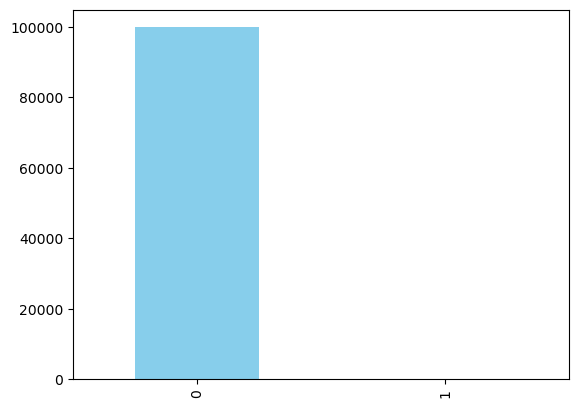

In [8]:
# Your response here
x = df["isFraud"].value_counts()
x.plot(kind="bar", color="skyblue")
plt.show()                            # 99870 to 130

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [17]:
# Your code here
type_dummies = pd.get_dummies(df["type"])
new_df = pd.concat([df, type_dummies], axis=1)
new_df.drop(["type", "DEBIT"],axis=1, inplace=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
new_df["day"] = new_df["step"]/30
new_df["day"] = new_df["day"].astype(int)

KeyError: 'step'

In [47]:
new_df["hour"] = new_df["step"]%24

In [33]:
new_df.drop(["nameOrig", "nameDest", "isFlaggedFraud", "step"], axis=1, inplace=True)

In [53]:
new_df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,PAYMENT,TRANSFER,day,hour
4598522,32736.40,590426.66,557690.26,0.00,0.00,0,0,0,1,0,10,16
5077450,300760.89,5558182.23,5858943.12,423160.44,122399.55,0,1,0,0,0,11,19
5563911,772630.81,0.00,0.00,1074556.05,1847186.85,0,0,0,0,1,13,9
1344831,18602.01,52154.00,33551.99,0.00,0.00,0,0,0,1,0,4,17
5080669,205936.10,21826.00,0.00,463633.37,669569.47,0,0,1,0,0,11,19


### Run a logisitc regression classifier and evaluate its accuracy.

In [57]:
# Your code here
features = new_df.drop("isFraud", axis=1)
label = new_df["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.20)

<IPython.core.display.Javascript object>

In [58]:
from sklearn.metrics import confusion_matrix
log = LogisticRegression()
log.fit(X_train, y_train)

print(log.score(X_test, y_test))
pred = log.predict(X_test)
print(confusion_matrix(y_pred = pred, y_true = y_test))

<IPython.core.display.Javascript object>

0.99935
[[19968     6]
 [    7    19]]


In [59]:
train = pd.concat([X_train, y_train], axis=1)

isnotFraud = train[train["isFraud"]==0]
isFraud = train[train["isFraud"]==1]

<IPython.core.display.Javascript object>

In [62]:
isnotFraud_under = resample(isnotFraud,
                            replace=False,
                            n_samples = 50000,
                            random_state=0)

In [65]:
train_under_sampled = pd.concat([isnotFraud_under, isFraud])

<IPython.core.display.Javascript object>

In [72]:
X_train_under = train_under_sampled.drop("isFraud", axis=1)
y_train_under = train_under_sampled["isFraud"]

In [73]:
sm = SMOTE(random_state=1, sampling_strategy= 1.0)
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train_under, y_train_under)

In [74]:
y_train_SMOTE.value_counts()

0    50000
1    50000
Name: isFraud, dtype: int64

In [75]:
log = LogisticRegression()
log.fit(X_train_SMOTE, y_train_SMOTE)

print(log.score(X_test, y_test))
pred = log.predict(X_test)
print(confusion_matrix(y_pred = pred, y_true = y_test))

<IPython.core.display.Javascript object>

0.98305
[[19635   339]
 [    0    26]]


In [76]:
## this way we were able to have no more false positives and this way not miss any fraudulent activity anymore!
## However at the same time we have more hits on false negatives.

### Now pick a model of your choice and evaluate its accuracy.

In [78]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)

print(tree.score(X_test, y_test))
pred = tree.predict(X_test)
print(confusion_matrix(y_pred = pred, y_true = y_test))

0.9993
[[19968     6]
 [    8    18]]


In [79]:
## first score very similiar to logistic regression. if anything a little bit worse.

In [80]:
tree = DecisionTreeClassifier()

tree.fit(X_train_SMOTE, y_train_SMOTE)

print(tree.score(X_test, y_test))
pred = tree.predict(X_test)
print(confusion_matrix(y_pred = pred, y_true = y_test))

0.99765
[[19932    42]
 [    5    21]]


### Which model worked better and how do you know?

In [81]:
# the logistic regression worked better as it got no more false positives with the balanced data. WHile the decision tree 
# even though the number of FPs also decreased still fot 5.

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.